## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys

In [2]:
sys.path.insert(0, os.getcwd()[:os.getcwd().rfind('\\')])
os.chdir(sys.path[0])

In [3]:
from scripts import Patient, Simulator, Filter
from scripts.filter import basic_rule_generator, sd_rule_generator, arv_rule_generator

## Data

In [4]:
df = pd.read_csv('data/diary_param.csv', sep='\t')
df.head()

,patient_id,doctor_id,MeasurementDateStart,MeasurementDateEnd,SystolicPressureMax,SystolicPressureMean,SystolicPressureMin,DiastolicPressureMax,DiastolicPressureMean,DiastolicPressureMin,PulseMax,PulseMean,PulseMin
0,194809,U6VN842K1A,2020-12-07T11:33:00+00:00,2020-12-07T11:33:00+00:00,138.0,138.0,138.0,76.0,76.0,76.0,52.0,52.0,52.0
1,194809,U6VN842K1A,2020-12-08T06:21:00+00:00,2020-12-08T06:21:00+00:00,122.0,122.0,122.0,65.0,65.0,65.0,51.0,51.0,51.0
2,194809,U6VN842K1A,2020-12-09T15:40:00+00:00,2020-12-09T15:40:00+00:00,110.0,110.0,110.0,55.0,55.0,55.0,56.0,56.0,56.0
3,194809,U6VN842K1A,2020-12-10T06:24:00+00:00,2020-12-10T06:24:00+00:00,110.0,110.0,110.0,60.0,60.0,60.0,52.0,52.0,52.0
4,194809,U6VN842K1A,2020-12-11T06:22:00+00:00,2020-12-11T06:22:00+00:00,102.0,102.0,102.0,55.0,55.0,55.0,51.0,51.0,51.0


In [5]:
patients = df.patient_id.unique()

## Experiments

### 1 patient

In [6]:
pat = patients[0]
df_1 = df[df.patient_id == pat]
df_1.to_csv(f'data/patient_{pat}', sep='\t', index=False)

In [7]:
p = Patient(f'data/patient_{pat}')

In [8]:
n_days = 30
sim = Simulator(p)
sim.run_simulation(n_days)

In [9]:
os.remove(f'data/patient_{pat}')  # don't need it anymore

In [10]:
for meas in sim.measurements:
    print(meas.sbp, meas.dbp)  # -1 is a missing measurement

-1 -1
108 61
120 79
107 54
-1 -1
116 67
110 61
104 45
-1 -1
105 61
101 49
115 70
122 74
116 70
110 70
117 70
108 68
110 62
110 54
121 63
108 66
112 71
108 59
115 64
113 58
101 52
113 72
104 59
105 65
101 50


In [11]:
# it's cool that when sbp (dbp) is -1, the map will be -1 :)
map_values = np.array([(meas.sbp + 2 * meas.dbp) / 3 for meas in sim.measurements])  # MAP is the mean arterial pressure

In [12]:
f = Filter(sim.measurements,
           [
               basic_rule_generator,
               sd_rule_generator,
               arv_rule_generator,
           ])

In [13]:
results = f.apply()[:]

In [14]:
def filter_missing(meas_array, apply_array):
    return np.where(meas_array == -1, None, apply_array)  # -1 is a missing measurement

In [15]:
filtered_vals = filter_missing(map_values, map_values)

In [16]:
def plot_meas_series(vals, checks, title=None):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(vals, 'o--', markersize='4')
    ax.plot(np.where(checks == True, None, vals), 'x', markersize='6', label='alerts')
    ax.set_xlabel('measurement number')
    ax.set_ylabel('MAP')
    ax.set_title(title)
    ax.legend();
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

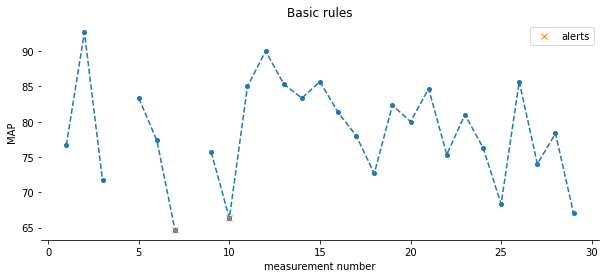

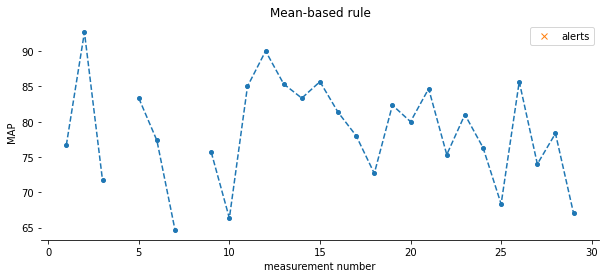

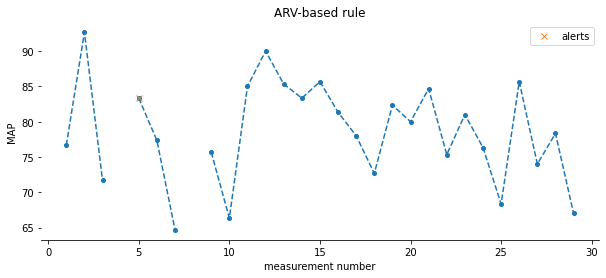

In [17]:
for checks, rule in zip(results, ['Basic rules', 'Mean-based rule', 'ARV-based rule']):
    plot_meas_series(filtered_vals, filter_missing(map_values, checks), rule)